In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.losses import kld
from tensorflow.keras.utils import to_categorical

from CustomModels import utils 
import CustomModels.metrics as metrics
import CustomModels.rank_metrics as rank_metrics

from tensorflow.keras import Model
# from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Dropout#,CuDNNLSTM,CuDNNGRU
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


# 0. Setup

 Setting up necessary functions and sanity-checking dataset, actual thing starts at chapter 1. <br>
 By Sokolov Gleb <br>
 Part of job application @ ООО ИК QBF

In [2]:
# K-L divergence and Jensen-Shannon divergence, presumably J-S is better
# wiki explaines this https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

def ckld(vec_true, vec_compare):
    t = vec_true * K.log(vec_true / vec_compare)
    t = tf.where(tf.is_nan(t), tf.zeros_like(t), t)
    return K.sum(t)

def jsd(y_true, y_pred):
    y_mean = 0.5 * (y_true + y_pred)
    return 0.5 * kld(y_true, y_mean) + 0.5 * kld(y_pred, y_mean)


In [3]:
# wrapper for tf - to - keras metrics usage
def as_keras_metric(method):
    import functools
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

In [4]:
# experimenting with metrics, custom tf metrics is a no go at the moment for Keras 
ndcg_metric = as_keras_metric(metrics.make_ranking_metric_fn(metrics.RankingMetricKey().DCG))

In [237]:
# Testing set at given linear regression problem,things are getting explained in part 1.
m = 1000
n = 5
f = 1
qs = ['date_'+str(i) for i in range(m)]
qs = np.array(sorted(qs*n))
scores = np.random.random(m*n)
features = (2*scores+np.random.normal(0,.1,m*n)).reshape((f,-1))
#features = np.random.random(m*n*f).reshape((f,-1))
features = [fi.astype('float32') for fi in features]
feature_names = ['F'+str(i+1) for i in range(f)]

In [238]:
#Sample dataframe data example 
df = pd.DataFrame(dict(zip(['Q_id','Score',*feature_names],[qs,scores,*features])))
df.head(6)

,Q_id,Score,F1
0,date_0,0.154613,0.349917
1,date_0,0.202196,0.301570
2,date_0,0.271071,0.500666
3,date_0,0.813830,1.622931
4,date_0,0.732603,1.459348
5,date_1,0.940675,1.771619


In [239]:
# either this or next block should be run
#groupng stocks at each trading day (Queue)
d = df.groupby('Q_id').groups.values()
X = np.array([df.loc[g,feature_names].values.T[0] for g in d])
y = np.array([df.loc[g,'Score'].values for g in d])

In [240]:
# Do simple all in one multi-dimensional space
X = df[feature_names].values
y = df.Score.values.reshape((-1,1))

# 1. Adaptation of ListNet for ranking stocks

First of all, there is no Keras version of Listnet that I found, so lets get educated and implement maths. <br>


To adapt our problem to ranking scheme, lets get along with great paper for listwise ranking learning: "Learning to Rank: From Pairwise Approach to Listwise Approach" (https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-2007-40.pdf).<br>


In training, we have a list of stocks for each trading day: $ D = \{d^{(1)},d^{(2)}, ... , d^{(n)} \}$. Each day associated with a list of stocks $ S^{(i)} = \{s^{(i)}_1, s^{(i)}_2, ... , s^{(i)}_m \}$. Furthermore, each stock $S^{(i)}$ is associated with list of independent ranking scores $ y^{(i)} = \{y^{(i)}_1, y^{(i)}_2, ... , y^{(i)}_m \}$ <br>

For now i will go only with $S^{(i)}$ data, droping possible impact of $D$. In the other way it will recuire redoing tensorflow computation graph from scratch, and this research is more of display of skill kinda work.  So $x^{(i)}_j = \Psi (s^{(i)}_j)$, $i = 1,2,\dots,n, j = 1,2,\dots,m$. <br>

Each list of features $x^{(i)}= (x^{(i)}_1, x^{(i)}_2, ... , x^{(i)}_m)$ and the corresponding list of given ranks $ y^{(i)} =  (y^{(i)}_1, y^{(i)}_2, ... , y^{(i)}_m )$ then form an "instance". Training set can be denoted as $ \mathcal{T} = \big\{ (x^{(i)},y^{(i)}) \big\}^m_{i=1}$

We then create a ranking function $f$ for each feature vector $x^{(i)}_j$ (corresponding to stock $s^{(i)}_j$) it outputs a score $f(x^{(i)}_j)$. For list of feature vectors we obtain a list of scores $z^{(i)} = \big(f(x^{(i)}_1),f(x^{(i)}_2),\dots,f(x^{(i)}_m) \big)$

The objective of learning is formalized as minimization of the total losses with respect to the training data.
$$ \sum_{i=1}^{m} L(y^{(i)},z^{(i)})$$
where $L$ is a listwise loss function. I choose to use Jensen-Shannon divergence as loss function:
$$ D_{js}(P,Q) = \frac{1}{2} D_{kl}(P,M) + \frac{1}{2} D_{kl}(Q,M)$$
$$M = \frac{1}{2}(P+Q) $$
$$D_{kl}(P,Q) = - \sum_{i} P(i) \log \bigg(\frac{Q(i)}{P(i)} \bigg) $$
where P and Q are dicrete probability distributions. Lets get dangerous!

In [223]:
TT_SPLIT_SIZE = .8


In [213]:
# market ranks data
with open('./data/ranks.pkl','rb') as f:
    market = pickle.load(f)
market = market.Technology.dropna()
market = market.reindex(sorted(market.columns),axis=1)

In [214]:
X = market.loc[:,(slice(None),('P/E_rank','PEG_rank','MOM_rank'))].values
y = market.loc[:,(slice(None),('r_sum_rank'))].values

In [220]:
X.shape,y.shape

((39264, 60), (39264, 20))

In [224]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=TT_SPLIT_SIZE,shuffle=False)
X_train,X_test = X_train.reshape((-1,3)),X_test.reshape((-1,3))
y_train,y_test = y_train.ravel(),y_test.ravel()

In [225]:
X_train.shape,y_test.shape

((157040, 3), (628240,))

In [228]:
m,f,n = *X_train.shape,1
m,n,f

(157040, 1, 3)

In [202]:
K.clear_session()

In [ ]:
inputs = Input(shape=(f*n,))
x = inputs
x = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(1e-6,1e-6))(x)
x = BatchNormalization()(x)
x = Dropout(.2)(x)
x = Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(1e-6,1e-6))(x)
x = BatchNormalization()(x)
x = Dropout(.2)(x)
#x = Dense(32, activation='relu',activity_regularizer=tf.keras.regularizers.l1_l2(1e-4,1e-4))(x)
pred = Dense(1, activation='tanh')(x)

model = Model(inputs=inputs, outputs=pred)


In [204]:
model.compile(optimizer='adam',
              metrics=[tf.keras.metrics.mse],
              loss=jsd)

In [209]:
model.fit(X_train,y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_split=.2,
          shuffle=True)

Train on 25128 samples, validate on 6283 samples
Epoch 1/50
25128/25128 [==============================] - 1s 54us/step - loss: 0.3660 - mean_squared_error: 0.4990 - val_loss: 0.8007 - val_mean_squared_error: 0.6053
Epoch 2/50
25128/25128 [==============================] - 1s 47us/step - loss: 0.3689 - mean_squared_error: 0.4752 - val_loss: 0.9567 - val_mean_squared_error: 0.7356
Epoch 3/50
25128/25128 [==============================] - 1s 47us/step - loss: 0.3315 - mean_squared_error: 0.4629 - val_loss: 0.4581 - val_mean_squared_error: 0.4259
Epoch 4/50
25128/25128 [==============================] - 1s 47us/step - loss: 0.3375 - mean_squared_error: 0.4539 - val_loss: 0.3054 - val_mean_squared_error: 0.3823
Epoch 5/50
25128/25128 [==============================] - 1s 47us/step - loss: 0.3676 - mean_squared_error: 0.4705 - val_loss: 0.6956 - val_mean_squared_error: 0.5014
Epoch 6/50
25128/25128 [==============================] - 1s 49us/step - loss: 0.3686 - mean_squared_error: 0.4943 -

25128/25128 [==============================] - 1s 46us/step - loss: 0.2886 - mean_squared_error: 0.4143 - val_loss: 0.6654 - val_mean_squared_error: 0.5147
Epoch 50/50
25128/25128 [==============================] - 1s 44us/step - loss: 0.3509 - mean_squared_error: 0.5090 - val_loss: 0.6623 - val_mean_squared_error: 0.5240


In [210]:
y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred,axis=1).astype(int)

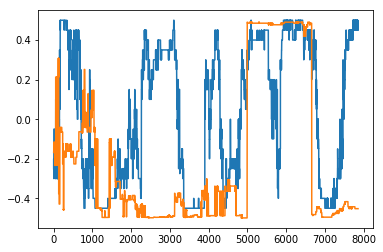

In [212]:
plt.plot(y_test)#[1::20])
plt.plot(y_pred/2)#[1::20]/2)

Links
1. Original paper: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-2007-40.pdf

2. JSD: https://en.wikipedia.org/wiki/Jensen–Shannon_divergence
3. KLD: https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

In [20]:
ls = []
for i in np.arange(0,100,2):
    t = 100
    a = np.random.random(t)#np.arange(t)/10
    b = a[:]#np.arange(t)/10

    k=i
    b = np.append(b[:k],np.random.random(t-k)/10)

    a = tf.constant(a)
    b = tf.constant(b)

    t = jsd(a,b)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ls.append(sess.run(t))

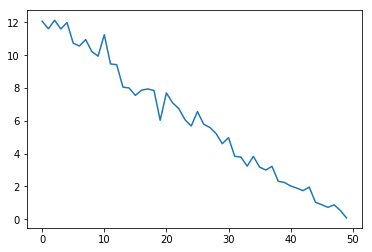

In [21]:
plt.plot(ls)